# 2 BatchNorm

In [1]:
import numpy as np
np.random.seed(1)

In [2]:
class BatchNorm:
    def __init__(self, n):
        self.w = np.ones(n)
        self.b = np.zeros(n)
            
    def forward(self, x):
        self.x = x
        self.mu = np.mean(x, axis=0)
        self.var = np.var(x, axis=0)
        self.z = (x-self.mu)/np.sqrt(self.var + 1e-7)
        self.y = self.w*self.z + self.b
        return self.y

    def backward(self, dy):
        self.dw = np.sum(dy*self.z, axis=0)
        self.db = np.sum(dy, axis=0)
        dz = self.w * dy
        dx = dz/np.sqrt(self.var + 1e-7)
        dvar = 2*(self.x-self.mu)/len(dy)* -0.5 / \
                (np.sqrt(self.var + 1e-7)**3) *\
                np.sum((self.x-self.mu)*dz, axis=0)
        dmu = -np.sum(dx + dvar, axis=0)/len(dy)
        self.dx = dx + dvar + dmu
        return self.dx

In [3]:
x = np.arange(15).reshape(3,5)
x

array([[ 0,  1,  2,  3,  4],
       [ 5,  6,  7,  8,  9],
       [10, 11, 12, 13, 14]])

In [4]:
bn = BatchNorm(5)

In [5]:
y = bn.forward(x)
y

array([[-1.22474487, -1.22474487, -1.22474487, -1.22474487, -1.22474487],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 1.22474487,  1.22474487,  1.22474487,  1.22474487,  1.22474487]])

In [6]:
print(np.mean(y,axis=0), np.std(y,axis=0))

[0. 0. 0. 0. 0.] [1. 1. 1. 1. 1.]


# 3 ライブラリとデータ

## 3.1 ライブラリとデータ

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
np.random.seed(1)

In [8]:
dataset = datasets.load_digits()
x = np.asarray(dataset.data)
t = np.asarray(dataset.target)

## 3.2 データの可視化

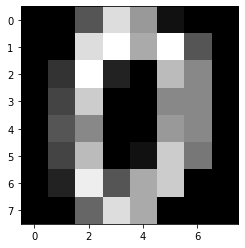

In [9]:
image = x[0,].reshape(8,8)
plt.imshow(image, cmap="binary_r")

In [10]:
t

array([0, 1, 2, ..., 8, 9, 8])

## 3.3 データの前処理

In [11]:
x.shape

(1797, 64)

In [12]:
x = (x - np.average(x)) / np.std(x)

In [13]:
t_zero = np.zeros((len(t), 10))
for i in range(len(t_zero)):
    t_zero[i, t[i]] = 1

In [14]:
x_train, x_test, t_train, t_test = train_test_split(x, t_zero)

In [15]:
x_train.shape, x_test.shape, t_train.shape, t_test.shape

((1347, 64), (450, 64), (1347, 10), (450, 10))

# 4 モデル

In [16]:
class Optimizer:
    def step(self, lr):
        self.w -= lr * self.dw
        self.b -= lr * self.db

class Linear(Optimizer):
    def __init__(self, x_n, y_n):
        self.w = np.random.randn(x_n, y_n) * np.sqrt(2/x_n)
        self.b = np.zeros(y_n)
    def forward(self, x):
        self.x = x
        self.y = np.dot(x, self.w) + self.b
        return self.y
    def backward(self, dy):
        self.dw = np.dot(self.x.T, dy)
        self.db = np.sum(dy, axis=0)
        self.dx = np.dot(dy, self.w.T)
        return self.dx
    
class BatchNorm(Optimizer):
    def __init__(self, n):
        self.w = np.ones(n)
        self.b = np.zeros(n)
    def forward(self, x):
        self.x = x
        self.mu = np.mean(x, axis=0)
        self.var = np.var(x, axis=0)
        self.z = (x-self.mu)/np.sqrt(self.var + 1e-7)
        self.y = self.w*self.z + self.b
        return self.y
    def backward(self, dy):
        self.dw = np.sum(dy*self.z, axis=0)
        self.db = np.sum(dy, axis=0)
        dz = self.w * dy
        dx = dz/np.sqrt(self.var + 1e-7)
        dvar = 2*(self.x-self.mu)/len(dy)* -0.5 / \
                (np.sqrt(self.var + 1e-7)**3) *\
                np.sum((self.x-self.mu)*dz, axis=0)
        dmu = -np.sum(dx + dvar, axis=0)/len(dy)
        self.dx = dx + dvar + dmu
        return self.dx    
    
class Relu:
    def forward(self, x):
        self.x = x
        y = np.where(self.x <= 0, 0, self.x)
        return y
    def backward(self, dy):
        dx =dy * np.where(self.x <= 0, 0, 1)
        return dx
    
class CELoss:
    def forward(self, x, t):
        self.t = t
        self.y = np.exp(x)/np.sum(np.exp(x), axis=1, keepdims=True) 
        L = -np.sum(t*np.log(self.y+1e-7)) / len(self.y)
        return L
    def backward(self):
        dx = self.y - self.t
        return dx

In [17]:
layer1 = Linear(64,32)
bn = BatchNorm(32)
relu = Relu()
layer2 = Linear(32,10)
celoss = CELoss()
def model(x):
    y1 = layer1.forward(x)
    y2 = bn.forward(y1)
    y3 = relu.forward(y2)
    y4 = layer2.forward(y3)
    return y4
def loss(y, t):
    L = celoss.forward(y, t)
    return L
def backward():
    dy4 = celoss.backward()
    dy3 = layer2.backward(dy4)
    dy2 = relu.backward(dy3)
    dy1 = bn.backward(dy2)
    layer1.backward(dy1)
def optimizer(lr):
    layer1.step(lr)
    bn.step(lr)
    layer2.step(lr)

# 5 モデルの学習

In [18]:
batch_size = 10
batch_n = len(x_train) // batch_size
batch_index = np.arange(len(x_train))

loss_train_all = []
loss_test_all = []

for epoch in range(1, 100 + 1):
    
    np.random.shuffle(batch_index)
    
    for n in range(batch_n):
        
        mb_index = batch_index[n*batch_size:(n+1)*batch_size]
        y = model(x_train[mb_index])
        loss_train = loss(y,t_train[mb_index])
        backward()
        optimizer(1e-3)
    
    y_train = model(x_train)
    loss_train = loss(y_train ,t_train)
    y_test = model(x_test)
    loss_test = loss(y_test ,t_test)
    
    loss_train_all.append(loss_train)
    loss_test_all.append(loss_test)
    

    if epoch == 1 or epoch % 20 == 0:
        print(f"Epoch {epoch}, loss_train {loss_train:.4f}, loss_test {loss_test:.4f}")

Epoch 1, loss_train 1.4172, loss_test 1.3825
Epoch 20, loss_train 0.1185, loss_test 0.1430
Epoch 40, loss_train 0.0564, loss_test 0.0897
Epoch 60, loss_train 0.0348, loss_test 0.0750
Epoch 80, loss_train 0.0227, loss_test 0.0662
Epoch 100, loss_train 0.0158, loss_test 0.0629


# 6 モデルの評価

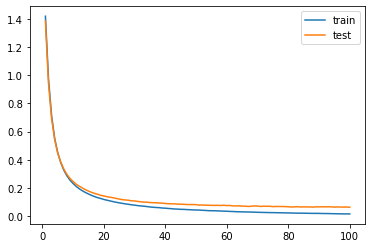

In [19]:
plt.plot(range(1,len(loss_train_all)+1), loss_train_all, label="train")
plt.plot(range(1,len(loss_test_all)+1), loss_test_all, label="test")
plt.legend()

In [20]:
def accuracy(x,t):
    acc = sum(model(x).argmax(axis=1) == t.argmax(axis=1))/len(t)
    return acc

In [21]:
print(accuracy(x_train,t_train), accuracy(x_test,t_test))

1.0 0.9911111111111112
